In [ ]:
import numpy as np
import pandas as pd
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from google.colab import drive
import time

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Fintech545/DailyReturn.csv")
data = data.iloc[:,1:]

In [ ]:
# Initializing array for storing weight
t = len(data['SPY'])
w = np.empty(t, dtype=float)

In [ ]:
# Vary lambda here for exponential 
lambda_value = 0.94
def weight_f(lambda_value):
  w = np.array([(1-lambda_value) * lambda_value**(i-1) for i in range(data.shape[0])])
  w = sorted(w/np.sum(w))
  return w
w = weight_f(lambda_value)

In [ ]:
# Function that calculate exponential weighted covariance
def exp_cov(X,Y):
  cov = 0
  xm = np.mean(X)
  ym = np.mean(Y)
  for i in range(t):
    cov += (w[t-i-1] * (X[t-i-1]-xm) * (Y[t-i-1]-ym))
  return cov

In [ ]:
def covmatrix(matrix):
  # initialize cov matrix.
  n = matrix.shape[1]
  covMatrix = np.zeros((n,n))
  for i in range(len(data.columns)):
    for j in range(len(data.columns)):
      covMatrix[i][j] = exp_cov(data.iloc[:, i], data.iloc[:,j])
  return covMatrix

In [ ]:
# The result of cov matrix
cov_m = covmatrix(data)
print(cov_m)

[[8.25839218e-05 1.13157307e-04 1.32658493e-04 ... 1.15015729e-04
  6.51973440e-05 8.28276770e-05]
 [1.13157307e-04 2.61179609e-04 2.20642626e-04 ... 1.14994673e-04
  2.48273209e-05 8.33597068e-05]
 [1.32658493e-04 2.20642626e-04 3.29737461e-04 ... 5.98170234e-05
  2.51233125e-05 7.07802358e-05]
 ...
 [1.15015729e-04 1.14994673e-04 5.98170234e-05 ... 7.30215981e-04
  2.67284635e-04 2.02408061e-04]
 [6.51973440e-05 2.48273209e-05 2.51233125e-05 ... 2.67284635e-04
  2.96819677e-04 5.56068297e-05]
 [8.28276770e-05 8.33597068e-05 7.07802358e-05 ... 2.02408061e-04
  5.56068297e-05 2.54613778e-04]]


In [ ]:
def simulate_pca(a,nval=None):
    # Eigenvalue decomposition
    vals, vecs = np.linalg.eig(a)

    # flip the eigenvalues and the vectors
    flip = np.argsort(vals)[::-1]
    vals = vals[flip]
    vecs = vecs[:, flip]
    tv = np.sum(vals)

    posv = np.where(vals >= 1e-8)[0]
    if nval is not None:
        if nval < posv.shape[0]:
            posv = posv[:nval]
    vals = vals[posv]

    vecs = vecs[:, posv]
    return np.abs(np.sum(vals)/tv)

In [ ]:
X = np.arange(1,102)
Y = np.zeros(101)

In [ ]:
lamb=[0.1,0.3,0.4,0.5,0.6,0.7,0.8,0.95,0.9,0.95,0.97]

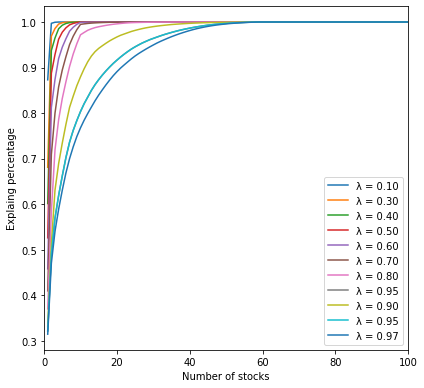

In [ ]:
plt.rcParams["figure.figsize"] = [6, 5.50]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
for i in range(len(lamb)):
  w = weight_f(lamb[i])
  covMatrix = covmatrix(data)
  for j in range(101):
    Y[j] = simulate_pca(covMatrix, nval=X[j])
  ax.plot(X,Y, label='\u03BB = {:.2f}'.format(lamb[i]) )
leg = ax.legend()
plt.xlabel('Number of stocks')
plt.ylabel('Explaing percentage')
plt.xlim([0,100])
plt.show()

# Problem 2

In [ ]:
# implement Cholesky function in python (not required!)
def cholesky(A):
    n = len(A)
    L = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1):
            s = sum(L[i][k] * L[j][k] for k in range(j))
            if i == j:
                L[i][j] = np.sqrt(A[i][i] - s)
            else:
                L[i][j] = (A[i][j] - s) / L[j][j]
    return L

In [ ]:
# Test cholesky on a non pd matrix
n = 5
sigma = np.full((n,n), 0.9)
for i in range(n):
    sigma[i][i] = 1.0
sigma[0][1]=1.0
sigma[1][0]=1.0
a = cholesky(sigma)
print(a)

[[1.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0. ]
 [0.9 nan nan 0.  0. ]
 [0.9 nan nan nan 0. ]
 [0.9 nan nan nan nan]]


<ipython-input-12-82e8a0960ba2>:11: RuntimeWarning: invalid value encountered in double_scalars
  L[i][j] = (A[i][j] - s) / L[j][j]


In [ ]:
# Reproduce chol_psd
def chol_psd(A):
  n = A.shape[1]
  root = np.zeros((n,n))
  
  # loop over columns
  for i in range(n):
    s = 0.0
    if i > 0:
      s = root[i][:i].T @ root[i][:i]
    
    # Diagonal Element
    temp = A[i][i] - s
    if temp <= 0 and temp >= -1e-8:
      temp = 0.0
    root[i][i] = np.sqrt(temp)

    # check for the 0 eign value. set the column to 0 if we have one
    if root[i][i] == 0.0:
      root[i][(i+1):n] = 0.0
    else:
      # update off diagonal rows of the column
      ir = 1.0/root[i][i]
      for j in np.arange(i+1,n):
        s = root[j][:i].T @ root[i][:i]
        root[j][i] = (A[j][i] -s) * ir
  return root

In [ ]:
# test chol_psd()
root = chol_psd(sigma)
root @ root.T

array([[1. , 1. , 0.9, 0.9, 0.9],
       [1. , 1. , 0.9, 0.9, 0.9],
       [0.9, 0.9, 1. , 0.9, 0.9],
       [0.9, 0.9, 0.9, 1. , 0.9],
       [0.9, 0.9, 0.9, 0.9, 1. ]])

In [ ]:
# Reproduce near_psd
def near_psd(a, epsilon=0.0):
  n = a.shape[0]


  invSD = None
  out = a.copy()

  #calculate the correlation matrix if we got a covariance
  if (np.count_nonzero(np.diag(out) == 1.0) != n):
      invSD = np.diag(1.0 / np.sqrt(np.diag(out)))
      out = np.dot(np.dot(invSD, out), invSD)

  #SVD, update the eigen value and scale
  vals, vecs = np.linalg.eigh(out)
  vals = np.maximum(vals, epsilon)
  T = 1.0 / (np.dot(np.dot(vecs, np.diag(vals)), vecs.T))
  T = np.diag(np.sqrt(np.diag(T)))
  l = np.diag(np.sqrt(vals))
  B = np.dot(np.dot(T, vecs), l)
  out = np.dot(B, B.T)

  #Add back the variance
  if invSD is not None:
      invSD = np.diag(1.0 / np.diag(invSD))
      out = np.dot(np.dot(invSD, out), invSD)
  return out

In [ ]:
# initialize a non-psd correlation matrix

n=500
sigma = np.ones((n,n))*0.9
for i in range(n):
  sigma[i,i]=1.0
sigma[0,1] = 0.7357
sigma[1,0] = 0.7357

In [ ]:
# Create Higham's method that turn non pd to psd
def higham(R, tol=10):
  state = True
  while state is True:
    λ, V = eigh(R)
    check = 0
    for i in λ:
      if i < -1e-8:
        check +=1
    if check == 0 or tol <0:
      state = False
      break
    D = np.diag(np.maximum(λ,0))
    R = V @ D @ V.T
    tol -= 1
  return R


In [ ]:
# Make non pd matrix psd
after_near = near_psd(sigma)
after_hig = higham(sigma)

In [ ]:
# test if near_psd and higham function success transfer to psd correlation matrix
test1 = chol_psd(after_near)
test2 = chol_psd(after_hig)
print(test1 - test2)

[[-1.57235480e-02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.16954811e-02 -1.05093141e-02  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.26277258e-07 -8.67287982e-08 -8.06861290e-08 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-2.26277384e-07 -8.67288465e-08  1.62357718e-10 ... -6.59508089e-08
   0.00000000e+00  0.00000000e+00]
 [-2.26277385e-07 -8.67288467e-08  1.62353852e-10 ...  3.29616624e-08
  -5.71230097e-08  0.00000000e+00]
 [-2.26277385e-07 -8.67288468e-08  1.62355961e-10 ...  3.29617140e-08
   5.70754969e-08  0.00000000e+00]]


In [ ]:
# Frobenius Norm
def frobenius_norm(matrix):
  return np.linalg.norm(matrix, 'fro')

In [ ]:
# Test time diff when n = 500
start1 = time.time()
after_near = near_psd(sigma)
end1 = time.time()
after_hig = higham(sigma)
end2 = time.time()
print("Near_psd takes:",end1-start1)
print("Higham takes: ", end2-end1)

Near_psd takes: 0.09268403053283691
Higham takes:  0.15073323249816895


In [ ]:
f_near = frobenius_norm(after_near)
f_hig = frobenius_norm(after_hig)
f_sig = frobenius_norm(sigma)
print("Frobenius norm difference of near_psd: {:.3}".format(np.abs(f_near-f_sig)))
print("Frobenius norm difference of higham: {:.4}".format(np.abs(f_hig-f_sig)))


Frobenius norm difference of near_psd: 0.0555
Frobenius norm difference of higham: 4.499e-06


In [ ]:
# test higher n
n=2000
sigma = np.ones((n,n))*0.9
for i in range(n):
  sigma[i,i]=1.0
sigma[0,1] = 0.7357
sigma[1,0] = 0.7357

In [ ]:

start1 = time.time()
after_near = near_psd(sigma)
end1 = time.time()
after_hig = higham(sigma)
end2 = time.time()

In [ ]:
f_near = frobenius_norm(after_near)
f_hig = frobenius_norm(after_hig)
f_sig = frobenius_norm(sigma)
print("Frobenius norm difference of near_psd: {:.3}".format(np.abs(f_near-f_sig)))
print("Frobenius norm difference of higham: {:.4}".format(np.abs(f_hig-f_sig)))

print("Time for near_psd:",end1-start1)
print("Time for higham:",end2-end1)

Frobenius norm difference of near_psd: 0.0559
Frobenius norm difference of higham: 1.142e-06
Time for near_psd: 4.539523601531982
Time for higham: 4.865905284881592


In [ ]:
n=5000
sigma = np.ones((n,n))*0.9
for i in range(n):
  sigma[i,i]=1.0
sigma[0,1] = 0.7357
sigma[1,0] = 0.7357

start1 = time.time()
after_near = near_psd(sigma)
end1 = time.time()
after_hig = higham(sigma)
end2 = time.time()

In [ ]:
f_near = frobenius_norm(after_near)
f_hig = frobenius_norm(after_hig)
f_sig = frobenius_norm(sigma)
print("Frobenius norm difference of near_psd: {:.3}".format(np.abs(f_near-f_sig)))
print("Frobenius norm difference of higham: {:.4}".format(np.abs(f_hig-f_sig)))

print("Time for near_psd:",end1-start1)
print("Time for higham:",end2-end1)

Frobenius norm difference of near_psd: 0.056
Frobenius norm difference of higham: 4.803e-07
Time for near_psd: 79.2311098575592
Time for higham: 81.81068062782288


# Problem3

In [ ]:
# Get the unweighted data
nsim = 25000
corr_m = data.corr()
original_var =np.var(data, axis=0)
original_var.shape

(101,)

In [ ]:
# weighted variance

def exponential_weighted_variance(data,lambda_value):
    n = data.shape[0]
    m = data.shape[1]
    var = np.zeros((m,))
    weights = np.array([(1 - lambda_value) * lambda_value ** (i - 1) for i in range(n)])
    weights = sorted(weights/np.sum(weights))
    for i in range(m):
      xm = np.mean(data.iloc[:,i])
      var_sum = 0
      for j in range(n):
        var_sum += weights[n-1-j]*(data.iloc[:,i][n-1-j] - xm)**2
      var[i] = var_sum
    return var

lambda_value = 0.97
weighted_variance_vector = exponential_weighted_variance(data, lambda_value)

In [ ]:
# Get correlation from covariance and variance

def exponential_weighted_correlation(cov, var):
  std_vector = np.sqrt(var)

  corr = cov / np.outer(std_vector, std_vector)
  return corr


In [ ]:
lambda_value = 0.94
cov = covmatrix(data)
weighted_corr = exponential_weighted_correlation(cov,weighted_variance_vector)

In [ ]:
# Get covariance from correlation and variance

def return_cov(corr, var):
  std_vector = np.sqrt(var)
  cov = corr * np.outer(std_vector, std_vector)
  return np.array(cov)

In [ ]:
cov1 = return_cov(corr_m, original_var)
cov2 = return_cov(corr_m, weighted_variance_vector)
cov3 = return_cov(weighted_corr, weighted_variance_vector)
cov4 = return_cov(weighted_corr,original_var)

In [ ]:
def direct_simulation(cov,nsim):
  result = chol_psd(cov) @ np.random.standard_normal(size=(len(cov), nsim))
  return result

In [ ]:
def simulate_pca(a, nsim, perc):
    # Eigenvalue decomposition
    vals, vecs = np.linalg.eig(a)

    # flip the eigenvalues and the vectors
    flip = np.argsort(vals)[::-1]
    vals = vals[flip]
    vecs = vecs[:, flip]

    tv = np.sum(vals)
    start = 0
    while (np.abs(np.sum(vals[:start])/tv) <perc):
      start+=1
    vals = vals[:start]
    vecs = vecs[:, :start]
    print("Simulating with", start, "PC Factors: {:.2f}".format(np.abs(sum(vals)/tv*100)), "% total variance explained")
    B = np.matmul(vecs, np.diag(np.sqrt(vals)))
    m = B.shape[1]
    r = np.random.randn(m,nsim)
    return np.matmul(B, r)

In [ ]:
# Standard answer
FS = frobenius_norm(np.cov(data,rowvar=False))

Simulating with 96 PC Factors: 100.00 % total variance explained
Simulating with 12 PC Factors: 76.12 % total variance explained
Simulating with 4 PC Factors: 53.63 % total variance explained
Direct Simulation time: 0.2319
Norm difference for direct simulation: 0.000229
PCA with 100% explained time: 0.62907
Norm difference for PCA with 100% explained: 0.0002319
PCA with 75% explained time: 0.31058
Norm difference for PCA with 75% explained: 0.00020079
PCA with 50% explained time: 0.29501
Norm difference for PCA with 50% explained: 0.00062051


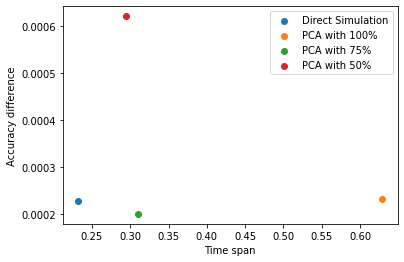

In [ ]:
# Matrix 1
a = time.time()
F1 = frobenius_norm(np.cov(direct_simulation(cov1,nsim)))
b = time.time()
F2 = frobenius_norm(np.cov(simulate_pca(cov1, nsim, perc=1)))
c = time.time()
F3 = frobenius_norm(np.cov(simulate_pca(cov1, nsim, perc=0.75)))
d = time.time()
F4 = frobenius_norm(np.cov(simulate_pca(cov1, nsim, perc=0.5)))
e = time.time()
print("Direct Simulation time: {:.5}".format(b-a))
print("Norm difference for direct simulation: {:.5}".format(np.abs(FS-F1)))
print("PCA with 100% explained time: {:.5}".format(c-b))
print("Norm difference for PCA with 100% explained: {:.5}".format(np.abs(FS-F2)))
print("PCA with 75% explained time: {:.5}".format(d-c))
print("Norm difference for PCA with 75% explained: {:.5}".format(np.abs(FS-F3)))
print("PCA with 50% explained time: {:.5}".format(e-d))
print("Norm difference for PCA with 50% explained: {:.5}".format(np.abs(FS-F4)))

x = np.array([b-a, c-b, d-c, e-d])
y = np.array([np.abs(FS-F1),np.abs(FS-F2), np.abs(FS-F3),np.abs(FS-F4)])
plt.scatter(x[0], y[0], label="Direct Simulation")
plt.scatter(x[1], y[1], label="PCA with 100%")
plt.scatter(x[2], y[2], label="PCA with 75%")
plt.scatter(x[3], y[3], label="PCA with 50%")
plt.xlabel("Time span")
plt.ylabel("Accuracy difference")
plt.legend()
plt.show()

Simulating with 65 PC Factors: 100.00 % total variance explained
Simulating with 12 PC Factors: 76.57 % total variance explained
Simulating with 4 PC Factors: 54.55 % total variance explained
Direct Simulation time: 0.14071
Norm difference for direct simulation: 0.00015219
PCA with 100% explained time: 0.25195
Norm difference for PCA with 100% explained: 0.00010467
PCA with 75% explained time: 0.15364
Norm difference for PCA with 75% explained: 0.00014974
PCA with 50% explained time: 0.14456
Norm difference for PCA with 50% explained: 0.00037502


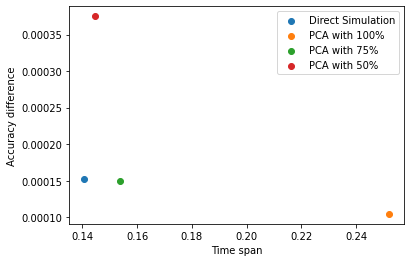

In [ ]:
# Matrix 2
a = time.time()
F1 = frobenius_norm(np.cov(direct_simulation(cov2,nsim)))
b = time.time()
F2 = frobenius_norm(np.cov(simulate_pca(cov2, nsim, perc=1)))
c = time.time()
F3 = frobenius_norm(np.cov(simulate_pca(cov2, nsim, perc=0.75)))
d = time.time()
F4 = frobenius_norm(np.cov(simulate_pca(cov2, nsim, perc=0.5)))
e = time.time()
print("Direct Simulation time: {:.5}".format(b-a))
print("Norm difference for direct simulation: {:.5}".format(np.abs(FS-F1)))
print("PCA with 100% explained time: {:.5}".format(c-b))
print("Norm difference for PCA with 100% explained: {:.5}".format(np.abs(FS-F2)))
print("PCA with 75% explained time: {:.5}".format(d-c))
print("Norm difference for PCA with 75% explained: {:.5}".format(np.abs(FS-F3)))
print("PCA with 50% explained time: {:.5}".format(e-d))
print("Norm difference for PCA with 50% explained: {:.5}".format(np.abs(FS-F4)))
x = np.array([b-a, c-b, d-c, e-d])
y = np.array([np.abs(FS-F1),np.abs(FS-F2), np.abs(FS-F3),np.abs(FS-F4)])
plt.scatter(x[0], y[0], label="Direct Simulation")
plt.scatter(x[1], y[1], label="PCA with 100%")
plt.scatter(x[2], y[2], label="PCA with 75%")
plt.scatter(x[3], y[3], label="PCA with 50%")
plt.xlabel("Time span")
plt.ylabel("Accuracy difference")
plt.legend()
plt.show()

Simulating with 59 PC Factors: 100.00 % total variance explained
Simulating with 11 PC Factors: 77.37 % total variance explained
Simulating with 5 PC Factors: 54.50 % total variance explained
Direct Simulation time: 0.13959
Norm difference for direct simulation: 0.0022145
PCA with 100% explained time: 0.24612
Norm difference for PCA with 100% explained: 0.0021125
PCA with 75% explained time: 0.15131
Norm difference for PCA with 75% explained: 0.0023404
PCA with 50% explained time: 0.14541
Norm difference for PCA with 50% explained: 0.0029265


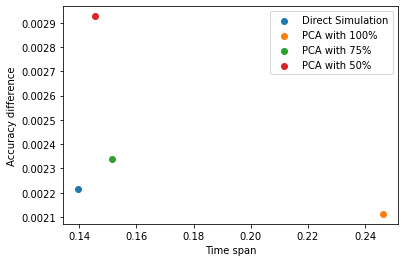

In [ ]:
# Matrix 3
a = time.time()
F1 = frobenius_norm(np.cov(direct_simulation(cov3,nsim)))
b = time.time()
F2 = frobenius_norm(np.cov(simulate_pca(cov3, nsim, perc=1)))
c = time.time()
F3 = frobenius_norm(np.cov(simulate_pca(cov3, nsim, perc=0.75)))
d = time.time()
F4 = frobenius_norm(np.cov(simulate_pca(cov3, nsim, perc=0.5)))
e = time.time()
print("Direct Simulation time: {:.5}".format(b-a))
print("Norm difference for direct simulation: {:.5}".format(np.abs(FS-F1)))
print("PCA with 100% explained time: {:.5}".format(c-b))
print("Norm difference for PCA with 100% explained: {:.5}".format(np.abs(FS-F2)))
print("PCA with 75% explained time: {:.5}".format(d-c))
print("Norm difference for PCA with 75% explained: {:.5}".format(np.abs(FS-F3)))
print("PCA with 50% explained time: {:.5}".format(e-d))
print("Norm difference for PCA with 50% explained: {:.5}".format(np.abs(FS-F4)))
x = np.array([b-a, c-b, d-c, e-d])
y = np.array([np.abs(FS-F1),np.abs(FS-F2), np.abs(FS-F3),np.abs(FS-F4)])
plt.scatter(x[0], y[0], label="Direct Simulation")
plt.scatter(x[1], y[1], label="PCA with 100%")
plt.scatter(x[2], y[2], label="PCA with 75%")
plt.scatter(x[3], y[3], label="PCA with 50%")
plt.xlabel("Time span")
plt.ylabel("Accuracy difference")
plt.legend()
plt.show()

Simulating with 59 PC Factors: 100.00 % total variance explained
Simulating with 10 PC Factors: 75.97 % total variance explained
Simulating with 5 PC Factors: 54.46 % total variance explained
Direct Simulation time: 0.13825
Norm difference for direct simulation: 0.0016417
PCA with 100% explained time: 0.25493
Norm difference for PCA with 100% explained: 0.0016174
PCA with 75% explained time: 0.14305
Norm difference for PCA with 75% explained: 0.0017779
PCA with 50% explained time: 0.14336
Norm difference for PCA with 50% explained: 0.002522


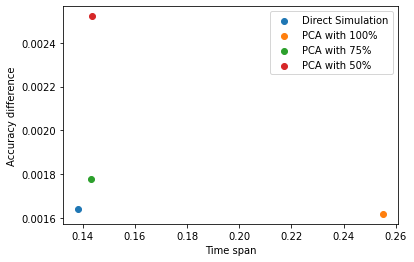

In [ ]:
# Matrix 4
a = time.time()
F1 = frobenius_norm(np.cov(direct_simulation(cov4,nsim)))
b = time.time()
F2 = frobenius_norm(np.cov(simulate_pca(cov4, nsim, perc=1)))
c = time.time()
F3 = frobenius_norm(np.cov(simulate_pca(cov4, nsim, perc=0.75)))
d = time.time()
F4 = frobenius_norm(np.cov(simulate_pca(cov4, nsim, perc=0.5)))
e = time.time()
print("Direct Simulation time: {:.5}".format(b-a))
print("Norm difference for direct simulation: {:.5}".format(np.abs(FS-F1)))
print("PCA with 100% explained time: {:.5}".format(c-b))
print("Norm difference for PCA with 100% explained: {:.5}".format(np.abs(FS-F2)))
print("PCA with 75% explained time: {:.5}".format(d-c))
print("Norm difference for PCA with 75% explained: {:.5}".format(np.abs(FS-F3)))
print("PCA with 50% explained time: {:.5}".format(e-d))
print("Norm difference for PCA with 50% explained: {:.5}".format(np.abs(FS-F4)))
x = np.array([b-a, c-b, d-c, e-d])
y = np.array([np.abs(FS-F1),np.abs(FS-F2), np.abs(FS-F3),np.abs(FS-F4)])
plt.scatter(x[0], y[0], label="Direct Simulation")
plt.scatter(x[1], y[1], label="PCA with 100%")
plt.scatter(x[2], y[2], label="PCA with 75%")
plt.scatter(x[3], y[3], label="PCA with 50%")
plt.xlabel("Time span")
plt.ylabel("Accuracy difference")
plt.legend()
plt.show()